<a href="https://colab.research.google.com/github/ta3map/MonkeyResearch/blob/main/MonkeyResearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalation of dependencies 
## For Google Colab

In [1]:
!git clone https://github.com/mariomulansky/PySpike.git

Cloning into 'PySpike'...
remote: Enumerating objects: 1798, done.
remote: Total 1798 (delta 0), reused 0 (delta 0), pack-reused 1798
Receiving objects: 100% (1798/1798), 16.53 MiB | 42.43 MiB/s, done.
Resolving deltas: 100% (1242/1242), done.


In [2]:
!cd PySpike && python setup.py install&> /dev/null

In [3]:
import sys
sys.path.insert(0,'/usr/local/lib/python3.7/dist-packages/pyspike-0.6.0-py3.7-linux-x86_64.egg')

In [4]:
!git clone https://github.com/ta3map/MonkeyResearch.git

Cloning into 'MonkeyResearch'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 89 (delta 14), reused 81 (delta 7), pack-reused 0
Unpacking objects: 100% (89/89), done.


In [7]:
main_folder = '/content'

## For standalone PC version:

In [ ]:
main_folder = 'F:\YandexDisk\MonkeysDatas'
import os
os.chdir(main_folder)

---

# Analysis
## 1. Choose the data folder (data_1, data_2, data_3)

In [73]:
data_folder = 'data_1'

### Pre-sets
#### Loading libraries and data settings from the corresponding xlsx protocol file

In [165]:
import numpy as np
import pyspike as spk
from MonkeyResearch import SpFun
from matplotlib import pyplot as plt
import pandas as pd
import pickle
from tqdm.notebook import tqdm

def loadData(data_folder):
  # read protocol
  filepath = main_folder + '/MonkeyResearch/protocol/' + data_folder + '.xlsx'
  protocol = pd.read_excel(filepath, sheet_name=0)
  set_properties = pd.read_excel(filepath, sheet_name=1)
  chosen_neuron_numbers = pd.read_excel(filepath, sheet_name=2)
  neuron_names = protocol['neuron_name'].tolist()

  # choose neurons
  # 2 for all neurons
  # 3 stable

  chosen_neurons = SpFun.GetNeuronNumbers(3, chosen_neuron_numbers)
  chosen_neuron_names = SpFun.GetNeuronNames(3, chosen_neuron_numbers)
  chosen_neurons_number = len(chosen_neurons)

  #% setA stimuli names and ranges
  set_names = set_properties['set names'].tolist()
  shows_number = int(set_properties['shows number'][0])
  pictures_number = int(set_properties['pictures number'][0])
  categories = len(set_names)
  neurons_number = len(protocol)

  return set_names, shows_number, pictures_number, categories, chosen_neurons, chosen_neuron_names, chosen_neurons_number

set_names, shows_number, pictures_number, categories, chosen_neurons, chosen_neuron_names, chosen_neurons_number = loadData(data_folder)

### Load Data

In [75]:
filepath = main_folder + '/MonkeyResearch/data/' + data_folder + ''
with open(filepath, 'rb') as f:
    spike_trains = pickle.load(f)
np.shape(spike_trains)

(36, 8, 15, 20)

(neurons, categories, pictures, showings)

**data_1** and **data_2** have a shape (36, 8, 15, 20):
- 36 neurons
- 8 categories
- 15 pictures
- 20 showings

**data_3** has a shape (74, 12, 10, 20):
- 74 neurons
- 12 categories
- 10 pictures
- 20 showings

Take only stable neurons

In [76]:
chosen_spike_trains = spike_trains[chosen_neurons,:,:]
np.shape(chosen_spike_trains)

(19, 8, 15, 20)

## 2. Extract spike-train parameters
### Directions

In [77]:
# get spike trains from the range (e.g. control or response times)
# getFromRange1D(spikeTrains[0,0,0,7]) # example
def getFromRange1D(Train, start_time, end_time):# for 1D spike train array
    return Train[(Train >= start_time) & (Train <= end_time)]
GetFromRange = np.vectorize(getFromRange1D, otypes=[object])# vectorization for multidimensional array

# changing the format according to PySpike library
def spikeTrain1D(Train, start_time, end_time):# for 1D spike train array
    edges = [start_time, end_time]
    if (np.size(Train)) == 0:
            Train = np.zeros(1)
            silent_neuron = True
    return spk.SpikeTrain(Train, edges)
SpikeTrains = np.vectorize(spikeTrain1D, otypes=[object])# vectorization for multidimensional array

# directionality matrix for single showing
def singleDirectionalityMatrix(spike_times, start_time, end_time, max_tau):
    Trains = SpikeTrains(spike_times, start_time, end_time)
    direction = spk.spike_directionality_matrix(Trains, max_tau = max_tau)
    return direction
#DirectionalityMatrix = np.vectorize(singleDirectionalityMatrix, otypes=[object])

def DirectionalityMatrix(Trains, max_tau, start_time=-1000, end_time=1000):# for multidimensional array
    categories = np.size(Trains, 1)
    pictures = np.size(Trains, 2)
    shows = np.size(Trains, 3)
    data_c = []# category (baby, grooming ...)
    for c in tqdm(range(categories)):
        data_p = []# pictures(1, 2, 3 ...)
        for p in range(pictures):
            data_s = []# shows (1, 2, 3 ...)
            for s in range(shows):
                spike_times = Trains[:, c, p, s]
                data = singleDirectionalityMatrix(spike_times, start_time, end_time, max_tau = max_tau)
                data = np.squeeze(data)
                data_s.append(data)
            data_p.append(data_s)
        data_c.append(data_p)
    return np.array(data_c)

### All Spike Trains
that we can get from the **control** and the **response** ranges

In [78]:
max_tau = 0
controlTrains = GetFromRange(chosen_spike_trains, start_time = -30, end_time = 80)
responseTrains = GetFromRange(chosen_spike_trains, start_time = 80, end_time = 180)
np.shape(controlTrains)

(19, 8, 15, 20)

### Example 1 - an instance of Directionality Matrix

An example of directionality matrix for **one showing**:
(**all neurons**, first category, first picture, first showing)

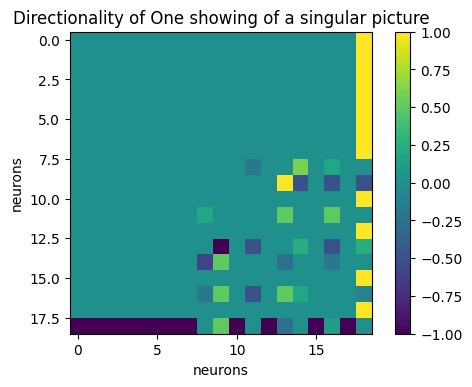

In [61]:
spike_times = responseTrains[:, 0, 0, 0]

Trains = SpikeTrains(spike_times, start_time = -1000, end_time = 1000)
direction = spk.spike_directionality_matrix(Trains, max_tau = 0)

plt.figure(0, dpi = 100)
plt.imshow(direction)
plt.xlabel('neurons')
plt.ylabel('neurons')
plt.colorbar()
plt.title('Directionality of One showing of a singular picture');

1 is leader, -1 is follower

### All directionality matrices 
that we can get from the **control** and the **response** ranges

In [62]:
control_D = DirectionalityMatrix(controlTrains, -100, 0)
response_D = DirectionalityMatrix(responseTrains, 100, 200)
effect_D = response_D - control_D
np.shape(effect_D)

(8, 15, 20, 19, 19)

Now we have **Directionality matrices of an effect** that correspond to all categories, all pictures, all showings. 

The shape is:
(categories, pictures, showings, neurons, neurons)


### Example 2 - average Directionality Matrix
Let's look at example of **average directionality matrix** of one picture from one category

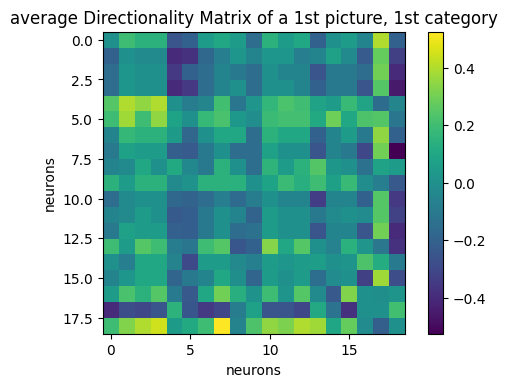

In [63]:
direction = np.mean(effect_D[0, 0, :], 0)# all showings of the first picture of the first category 
plt.figure(0, dpi = 100)
plt.imshow(direction)
plt.xlabel('neurons')
plt.ylabel('neurons')
plt.colorbar()
plt.title('average Directionality Matrix of a 1st picture, ' + '1st category');

### All average Directionality Matrices

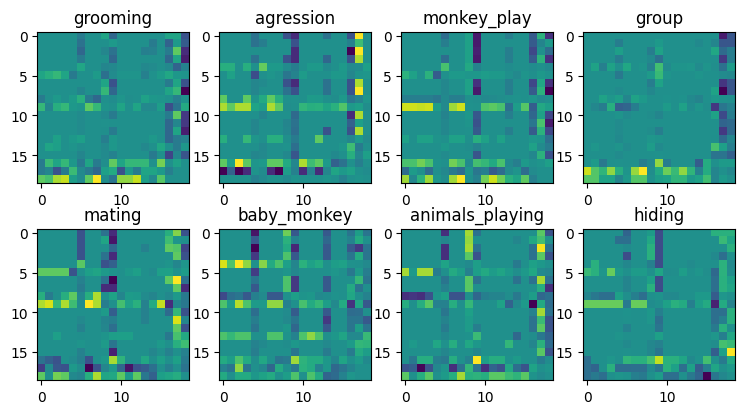

In [64]:
def AverageDirectionsPerPicture(D):
    categories = np.size(D, 0)
    pictures = np.size(D, 1)
    directions_c = []
    for c in range(categories):
        directions_p = []
        for p in range(pictures):
            direction = np.median(D[c, p, :], 0)
            directions_p.append(direction)
        directions_c.append(directions_p)
    return np.array(directions_c)

control_average_D = AverageDirectionsPerPicture(control_D)
response_average_D = AverageDirectionsPerPicture(response_D)
effect_D = response_average_D - control_average_D
#effect_D = response_average_D - np.mean(control_average_D, axis = (0,1) )
#effect_D = AverageDirectionsPerPicture(D)

s1 = int(categories/2)
s2 = int(categories/2)
plt.figure(figsize = [9,10], dpi = 100)
for c in range(categories):
    plt.subplot(s1, s2, 1+c)
    plt.imshow(np.mean(effect_D[c, :], 0))
    plt.title(set_names[c])
np.shape(effect_D)

#%% save picture
figure_title = 'AverageDirectionsPerPicture (' + data_folder + ")"
fname = main_folder + '/MonkeyResearch/' + figure_title + ' [Figure_degree_vs_type].png'
plt.savefig(fname)

#### Sorting

### Graphs
#### Making a graph for each showing

In [65]:
def Degrees(average_effect_D):
    indeg_c = []
    outdeg_c = []
    for c in tqdm(range(categories)):
        # make direction graph
        indegree, outdegree, G = SpFun.degrSet(average_effect_D[c],True, True)
        indeg_c.append(indegree)
        outdeg_c.append(outdegree)
    return np.array(indeg_c), np.array(outdeg_c)

indeg, outdeg = Degrees(effect_D)
np.shape(indeg)

(8, 15, 19)

In [66]:
#%% test for significant neurons (one-way Kruskal-Wallis ANOVA) 
from scipy.stats.mstats import kruskalwallis
def ifAllElementsAreEqual(arr_2d):
    # Get a flattened 1D view of 2D numpy array
    flatten_arr = np.ravel(arr_2d)
    # Check if all value in 2D array are equal
    return np.all(arr_2d==flatten_arr[0])

def NeuronsKruskalwallis(deg):
    p_values = [];
    stats = [];
    for n in range(0, np.size(deg, 2)):
        datas = deg[:, :, n].tolist()
        # check if all elements are the same
        if ifAllElementsAreEqual(datas):
            stat = 0
            p = 1
        else:
            stat, p = kruskalwallis(datas)
        p_values.append(p)
        stats.append(stat)
    return p_values, stats


chosen_categories = list(range(0,categories))# all types
#% one-way kruskalwallis
p_values_indeg, stats_indeg = NeuronsKruskalwallis(indeg[chosen_categories, :,:])
p_values_outdeg, stats_outdeg = NeuronsKruskalwallis(outdeg[chosen_categories, :,:])

[ 1  2  7  8 10 11 18]


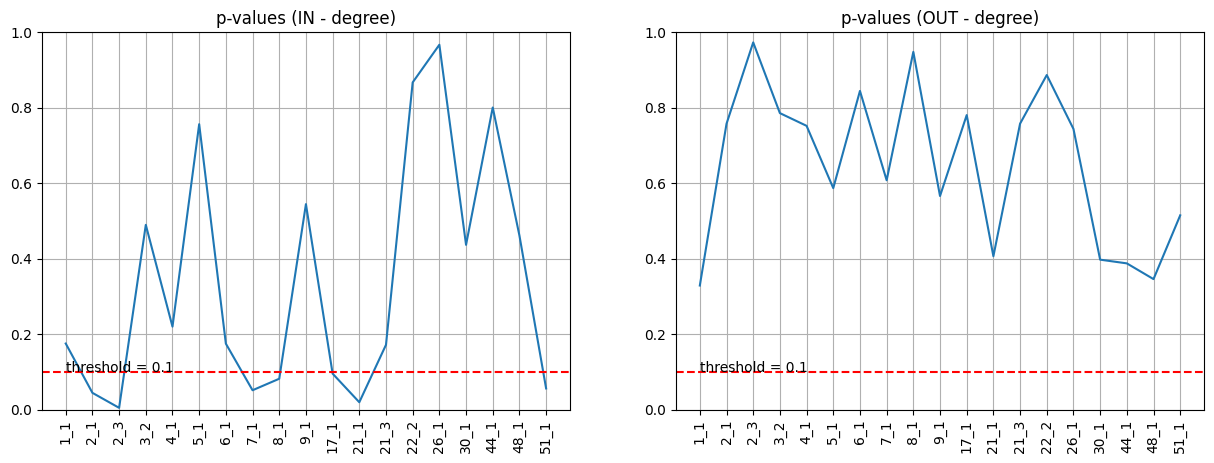

In [67]:
chosen_types = [0,1,2,3,4,5,6,7]# all types for data_1 and data_2
chosen_set_names = [set_names[i] for i in chosen_types];


mode = 1
# mode 0 - Bonferroni
# mode 1 - alpha
alpha = 0.1

if mode == 0:
    threshold = alpha/(chosen_neurons_number*stimuli_number)# Bonferroni
    mode_text = 'Bonferroni'
if mode == 1:
    threshold = alpha
    mode_text = 'p = '+str(alpha)
    
correct_p_indeg = np.asarray(p_values_indeg) < threshold
correct_p_indeg_indx = np.squeeze(np.asarray(np.where(correct_p_indeg)))
mean_indeg = np.transpose(np.mean(indeg[chosen_types,:,:], 1))

correct_p_outdeg = np.asarray(p_values_outdeg) < threshold
correct_p_outdeg_indx = np.squeeze(np.asarray(np.where(correct_p_outdeg)))
mean_outdeg = np.transpose(np.mean(outdeg[chosen_types,:,:], 1))

common_neurons = np.union1d(correct_p_indeg_indx, correct_p_outdeg_indx)

print(common_neurons)
np.shape(indeg)

def SubPlot(threshold, p_values, degree_type, chosen_neuron_names, chosen_neurons_number):
    plt.plot(p_values)
    plt.axhline(threshold, color='r', linestyle='--')
    plt.title('p-values ('+ degree_type + ' - degree)')
    plt.grid('on')
    plt.xticks(range(chosen_neurons_number), chosen_neuron_names, rotation=90);
    plt.text(0, threshold, 'threshold = ' + str(threshold))
    plt.ylim([0, 1])
    #plt.xlabel(['$'+chosen_neuron_names[i]+'$' for i in range(chosen_neurons_number)])
    
fig = plt.figure(figsize = [15,5], dpi = 100)
ax = fig.add_subplot(121)
SubPlot(threshold, p_values_indeg, 'IN', chosen_neuron_names, chosen_neurons_number)
ax = fig.add_subplot(122)
SubPlot(threshold, p_values_outdeg, 'OUT', chosen_neuron_names, chosen_neurons_number)

#%% save picture
figure_title = 'pvalues (' + data_folder + ")"
fname = main_folder + '/MonkeyResearch/' + figure_title + ' [Figure_degree_vs_type].png'
plt.savefig(fname)

Degree vs Category

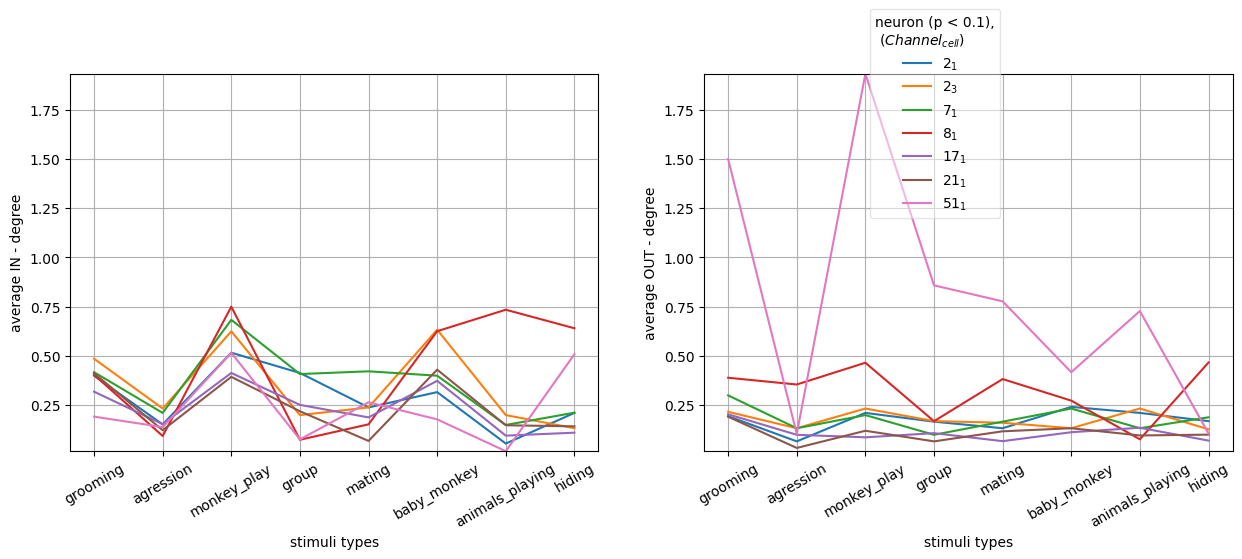

In [68]:
n_vs_stim_indeg = np.transpose(mean_indeg[common_neurons, :])
n_vs_stim_outdeg = np.transpose(mean_outdeg[common_neurons, :])

legend_title = 'neuron ('+ 'p < ' + str(threshold) + '),\n ($Channel_{cell}$)'
max_Y = np.max([n_vs_stim_indeg, n_vs_stim_outdeg])
min_Y = np.min([n_vs_stim_indeg, n_vs_stim_outdeg])
fig = plt.figure(figsize = [15,5], dpi = 100)

def SubPlot(n_vs_stim, chosen_set_names, degree_type):
    plt.plot(n_vs_stim)
    plt.ylabel('average ' + degree_type + ' - degree')
    plt.grid('on')
    plt.xticks(range(len(chosen_set_names)), chosen_set_names, rotation=30);
    plt.xlabel('stimuli types')
    plt.ylim([min_Y, max_Y])

ax = fig.add_subplot(121)
SubPlot(n_vs_stim_indeg, chosen_set_names, 'IN')
ax = fig.add_subplot(122)
SubPlot(n_vs_stim_outdeg, chosen_set_names, 'OUT')

plt.legend(['$'+chosen_neuron_names[i]+'$' for i in common_neurons], title=legend_title, framealpha=0.5,
           bbox_to_anchor=(0.30, 0.60))

#%% save picture
figure_title = 'degree vs type (' + data_folder + ")"
fname = main_folder + '/MonkeyResearch/' + figure_title + ' [Figure_degree_vs_type].png'
plt.savefig(fname)

One big function to optimize

In [170]:
from IPython.display import clear_output

def countAll(spike_trains,max_tau, control_times, response_times):

  chosen_spike_trains = spike_trains[chosen_neurons,:,:]
  # trains
  controlTrains = GetFromRange(chosen_spike_trains, start_time = control_times[0], end_time = control_times[1])
  responseTrains = GetFromRange(chosen_spike_trains, start_time = response_times[0], end_time = response_times[1])
  # directions
  control_D = DirectionalityMatrix(controlTrains, max_tau, start_time = control_times[0], end_time = control_times[1])
  response_D = DirectionalityMatrix(responseTrains, max_tau, start_time = response_times[0], end_time = response_times[1])
  #effect_D = response_D - control_D

  # per picture
  control_average_D = AverageDirectionsPerPicture(control_D)
  response_average_D = AverageDirectionsPerPicture(response_D)
  effect_D = response_average_D - control_average_D


  # graphs
  indeg, outdeg = Degrees(effect_D)

  # statistics
  chosen_categories = list(range(0,categories))# all types
  #% one-way kruskalwallis
  p_values_indeg, stats_indeg = NeuronsKruskalwallis(indeg[chosen_categories, :,:])
  p_values_outdeg, stats_outdeg = NeuronsKruskalwallis(outdeg[chosen_categories, :,:])

  correct_p_indeg = np.asarray(p_values_indeg) < threshold
  correct_p_indeg_indx = np.squeeze(np.asarray(np.where(correct_p_indeg)))
  mean_indeg = np.transpose(np.mean(indeg[chosen_types,:,:], 1))

  correct_p_outdeg = np.asarray(p_values_outdeg) < threshold
  correct_p_outdeg_indx = np.squeeze(np.asarray(np.where(correct_p_outdeg)))
  mean_outdeg = np.transpose(np.mean(outdeg[chosen_types,:,:], 1))

  common_neurons = np.union1d(correct_p_indeg_indx, correct_p_outdeg_indx)

  n_vs_stim_indeg = np.transpose(mean_indeg[common_neurons, :])
  n_vs_stim_outdeg = np.transpose(mean_outdeg[common_neurons, :])
  
  clear_output(wait=True)

  return n_vs_stim_indeg, n_vs_stim_outdeg

data_folder = 'data_2'
set_names, shows_number, pictures_number, categories, chosen_neurons, chosen_neuron_names, chosen_neurons_number = loadData(data_folder)

filepath = main_folder + '/MonkeyResearch/data/' + data_folder + ''
with open(filepath, 'rb') as f:
    spike_trains = pickle.load(f)

control_times = [-30, 80]# [-100, 0]
response_times = [80, 180]# [100, 200]

taus = [0, 10, 20, 30, 40, 60, 100]
I = []
O = []
for max_tau in taus:
  n_vs_stim_indeg, n_vs_stim_outdeg = countAll(spike_trains, max_tau, control_times, response_times)
  I.append(n_vs_stim_indeg)
  O.append(n_vs_stim_outdeg)

ArpackError: ignored

Text(0.5, 0, 'stimuli types')

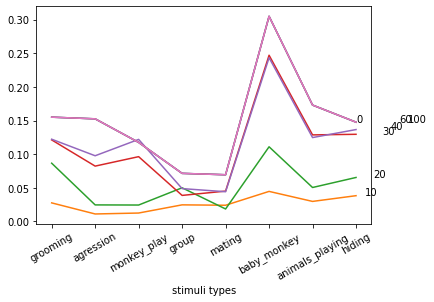

In [168]:
for i in range(np.size(taus)):
  O_m = np.mean(O[i], 1)
  plt.plot(O_m)
  plt.text(7+i*0.2,O_m[-1], taus[i])  
plt.xticks(range(len(chosen_set_names)), chosen_set_names, rotation=30);
plt.xlabel('stimuli types')

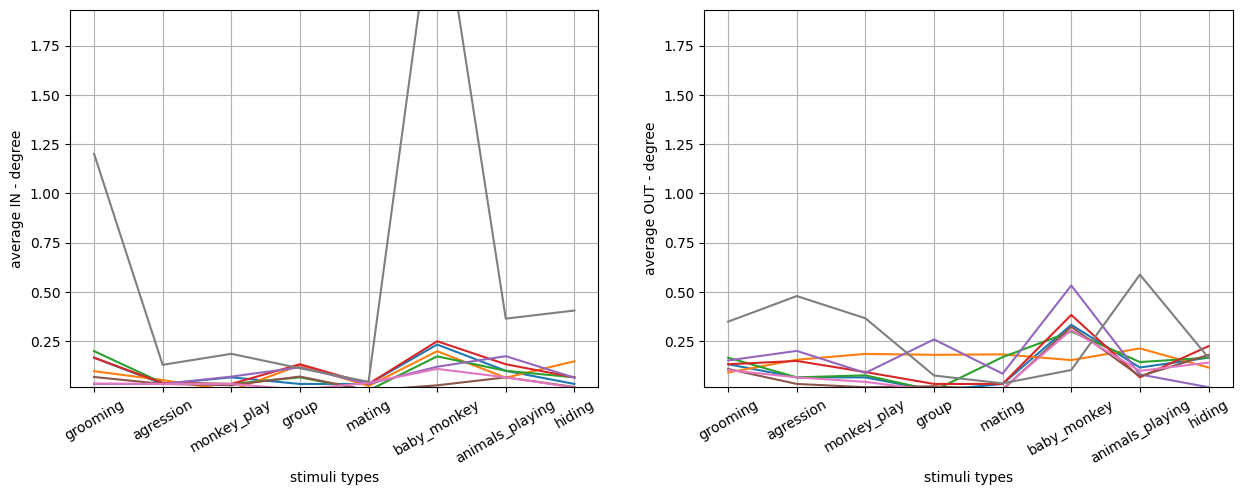

In [169]:
i = 6
n_vs_stim_outdeg = O[i]
n_vs_stim_indeg = I[i]

fig = plt.figure(figsize = [15,5], dpi = 100)
ax = fig.add_subplot(121)
SubPlot(n_vs_stim_indeg, chosen_set_names, 'IN')
ax = fig.add_subplot(122)
SubPlot(n_vs_stim_outdeg, chosen_set_names, 'OUT')

#plt.legend(['$'+chosen_neuron_names[i]+'$' for i in common_neurons], title=legend_title, framealpha=0.5,
#           bbox_to_anchor=(0.30, 0.60))


#### Node degrees

In [ ]:
# Save in-degrees and out-degrees

#### Statistics